# Time Series Forecasting

<span>This notebook demonstrates my solution to a time series problem posted on Kaggle. In the dataset, we have near 1 million training records from 1000 stores. We will need to use this information to predict the total sales for each day in the test set. The test set contains 40,000 records. During the modeling process, I created a few benchmark models to compare my LSTM's Neural Network performance against near the very end.</span>

**Dataset**

Rossman Dataset: https://www.kaggle.com/c/rossmann-store-sales/overview

### Import Preliminaries

In [28]:
# Import generic data science packages
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import modules
import datetime
import keras
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import missingno as msno
import numpy as np
import pandas as pd
import sqlalchemy
import sklearn
import seaborn as sns
import warnings

from keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Set pandas options
pd.set_option('max_columns',1000)
pd.set_option('max_rows',30)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting options
mpl.rcParams['figure.figsize'] = (8.0, 7.0)

### Import Data

The training and testing set have been given to us into separate CSV files, with an external file for the additional "store" data. I found empty string values in the data after importing the tabls from SQL, I wrote a quick "for" loop in the cell below, changing these empty string to null values. We will address how to handle the null values later on.

In [29]:
# Set your local database parameters 
db_username = 'root'
db_password = 'mypassword'
host = '127.0.0.1'
port = '3306'
db_name = 'rossman'

# Create a MySQLEngine
engine = sqlalchemy.create_engine('mysql+mysqldb://'+db_username+':'+db_password+'@\
'+host+':'+port+'/'+db_name)

# Connect to database
engine.connect();

# Import data from SQL
train_df = pd.read_sql(""" SELECT * FROM train""", engine,
                      parse_dates=['Date'],
                      ).dropna(how='any', axis=0)
test_df = pd.read_sql(""" SELECT * FROM test""", engine,
                     index_col='Id', parse_dates=['Date']
                     ).dropna(how='any', axis=0)
stores = pd.read_sql(""" SELECT * FROM store""", engine,
                     ).dropna(how='any', axis=0)

# Rename salse column to target
train_df.rename(columns={'Sales':'target'}, inplace=True)

# Replace empty string in store dataframe with Null Values
for col in stores:
    stores[col] = stores[col].replace('',np.nan)

    
# View head of store dataframe
stores.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.000,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.000,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620.000,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.000,4,2015,0,NaN,NaN,NaN
5,6,a,a,310.000,12,2013,0,NaN,NaN,NaN
6,7,a,c,24000.000,4,2013,0,NaN,NaN,NaN
7,8,a,a,7520.000,10,2014,0,NaN,NaN,NaN
8,9,a,c,2030.000,8,2000,0,NaN,NaN,NaN
9,10,a,a,3160.000,9,2009,0,NaN,NaN,NaN


In [30]:
# View head of the test dataframe
test_df.head(10)

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
Id,,,,,,,
1,1,4,2015-09-17,1.000,1,0,0
2,3,4,2015-09-17,1.000,1,0,0
3,7,4,2015-09-17,1.000,1,0,0
4,8,4,2015-09-17,1.000,1,0,0
5,9,4,2015-09-17,1.000,1,0,0
6,10,4,2015-09-17,1.000,1,0,0
7,11,4,2015-09-17,1.000,1,0,0
8,12,4,2015-09-17,1.000,1,0,0
9,13,4,2015-09-17,1.000,1,0,0


In [31]:
# View head of the train dataframe
train_df.head(10)

,Store,DayOfWeek,Date,target,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


### Data Completness


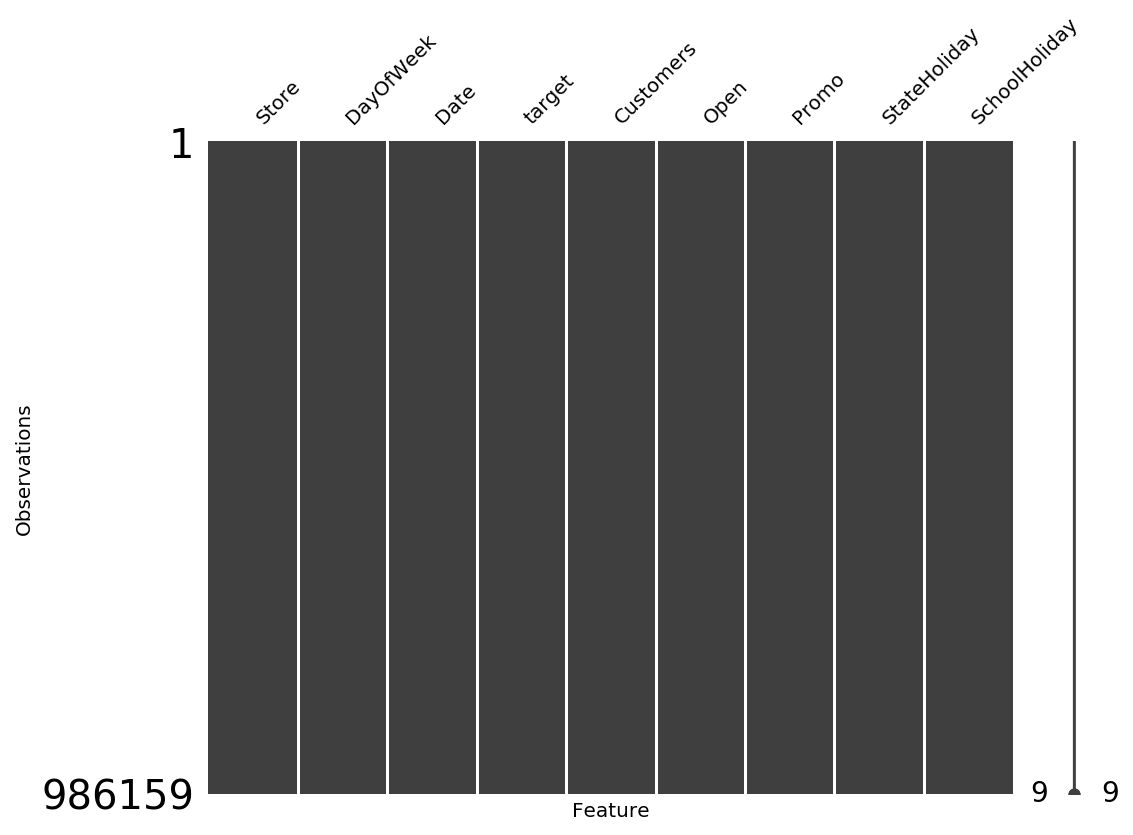

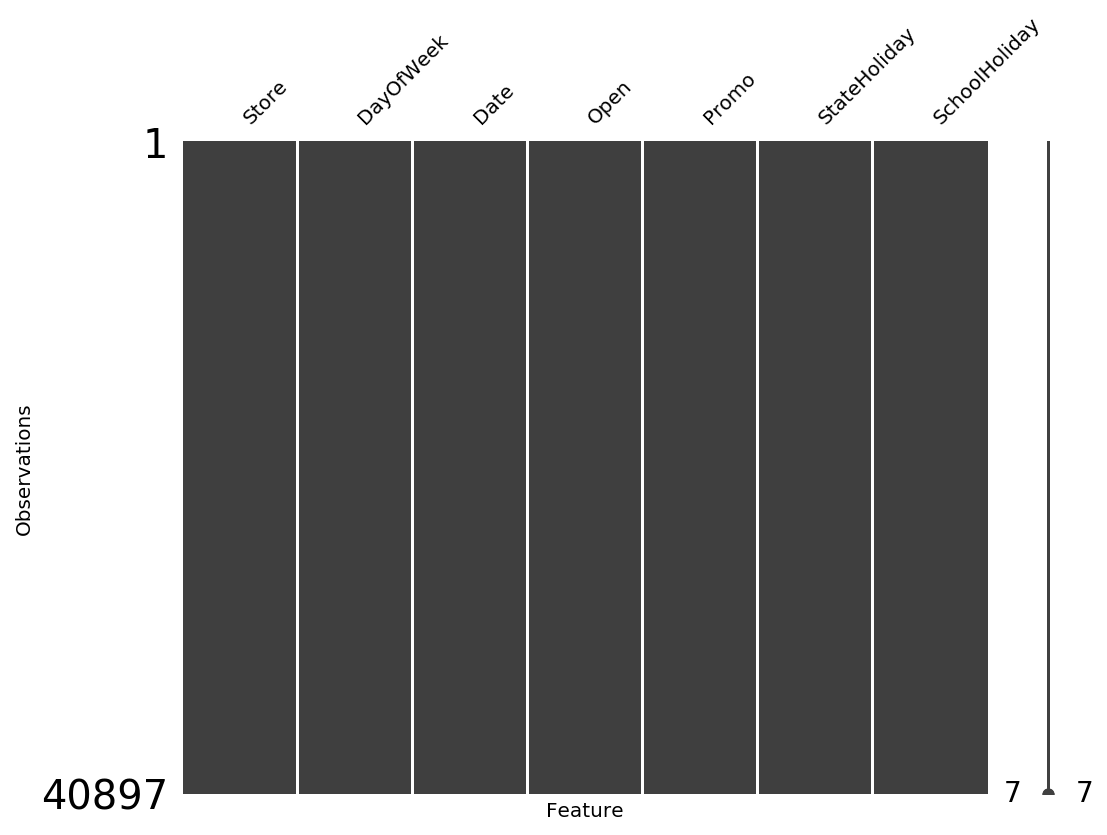

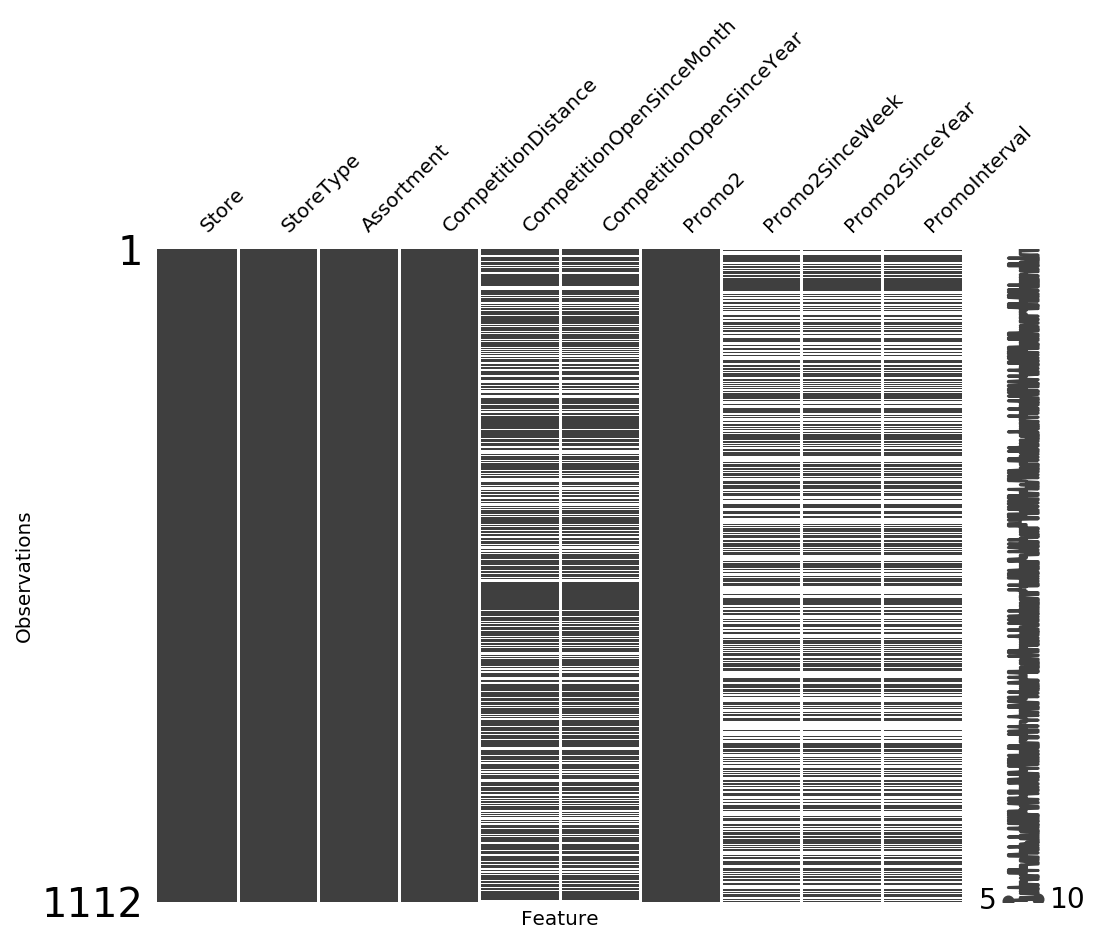

In [32]:
# Plot the null values from train, tets, and store dataframes
msno.matrix(train_df,  figsize=(8,6), fontsize=10);
plt.xlabel('Feature')
plt.ylabel('Observations');

msno.matrix(test_df,  figsize=(8,6), fontsize=10);
plt.xlabel('Feature')
plt.ylabel('Observations');

msno.matrix(stores,  figsize=(8,6), fontsize=10);
plt.xlabel('Feature')
plt.ylabel('Observations');

The training and testing are really clean but the store data seems to have many missing value for in couple of the features. I will address our methodology on how to handle these missing value under the "Feature Engineering" subsection.

### Data Overview

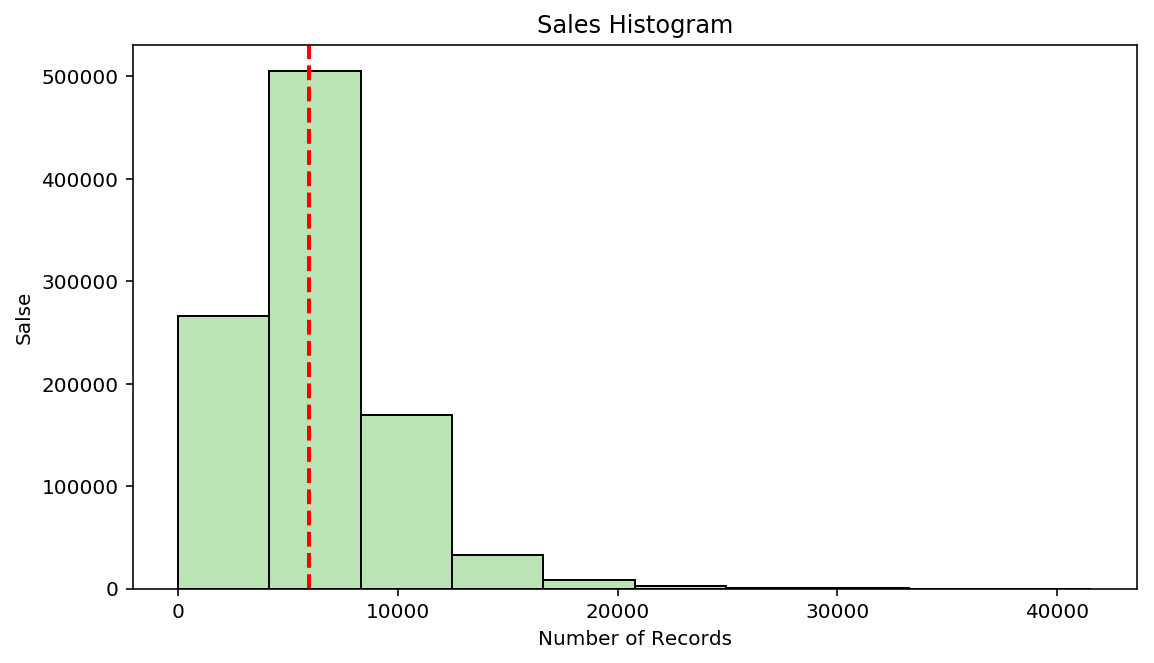

In [33]:
# Plot the distribution of target classes
train_df.target.plot.hist(figsize=(9,5),color='#BAE4B3', edgecolor='black')
plt.axvline(train_df.target.mean(), color='r', linestyle='dashed', 
            linewidth=2);
plt.title('Sales Histogram')
plt.ylabel('Salse')
plt.xlabel('Number of Records');

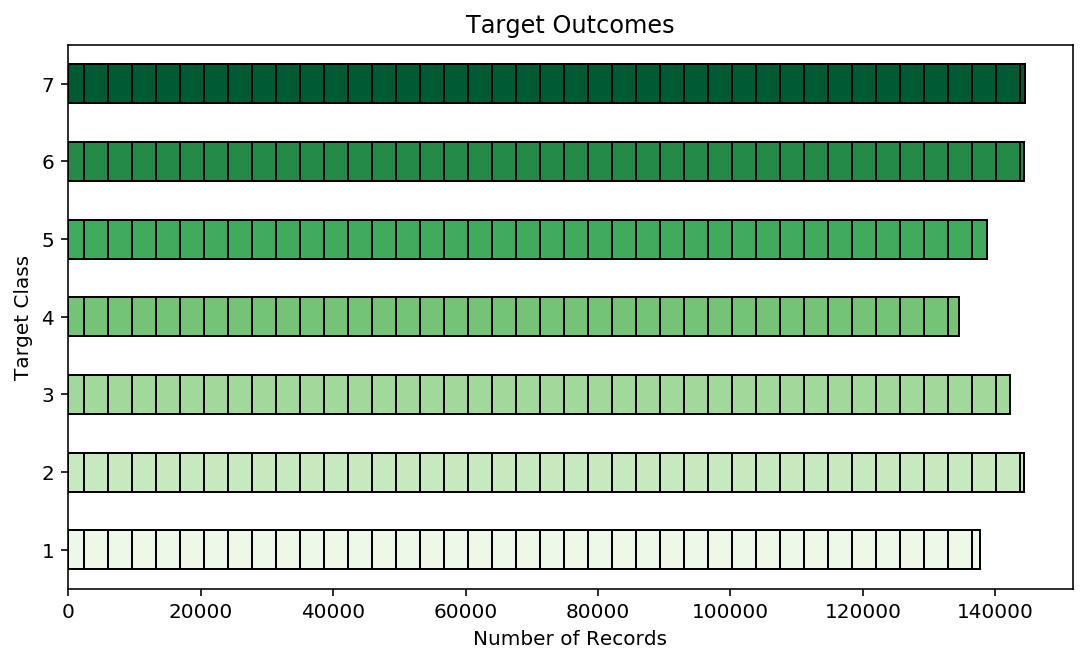

In [34]:
# Plot a barplot of the target clasees in our training set
# (1 = posinous, 0 = eatable by humans)
train_df.DayOfWeek.value_counts().sort_index().plot.barh(
                figsize = (9,5),
                grid=False, 
                color=['#edf8e9','#c7e9c0','#a1d99b','#74c476',
                  '#41ab5d','#238b45','#005a32'], 
                width=0.5, edgecolor='black',
                hatch='|')
plt.title('Target Outcomes')
plt.ylabel('Target Class')
plt.xlabel('Number of Records');

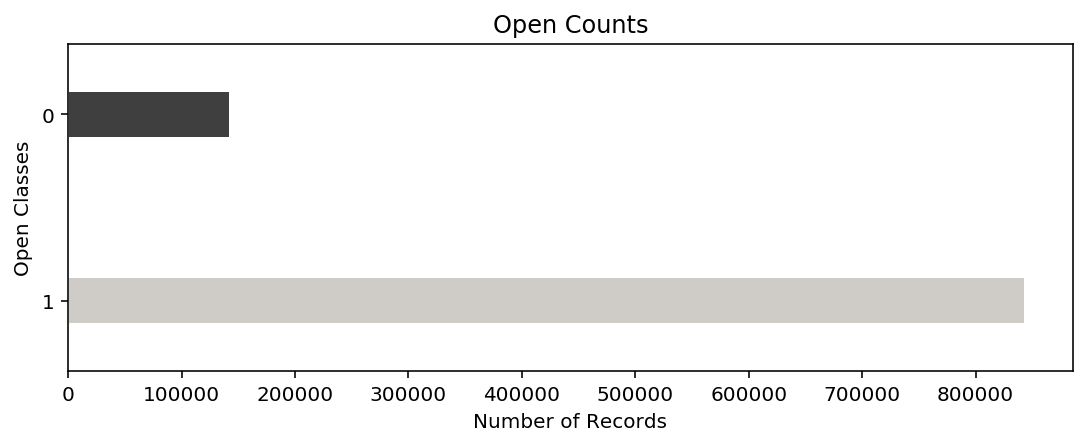

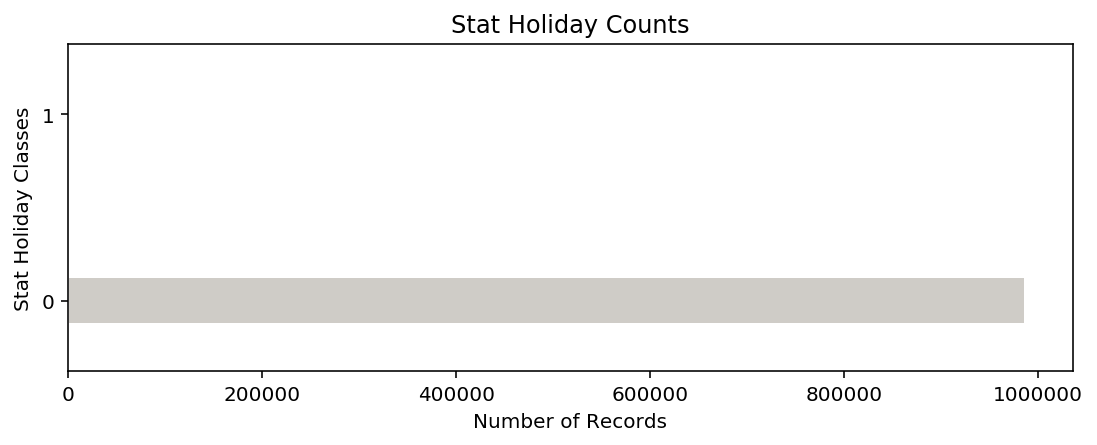

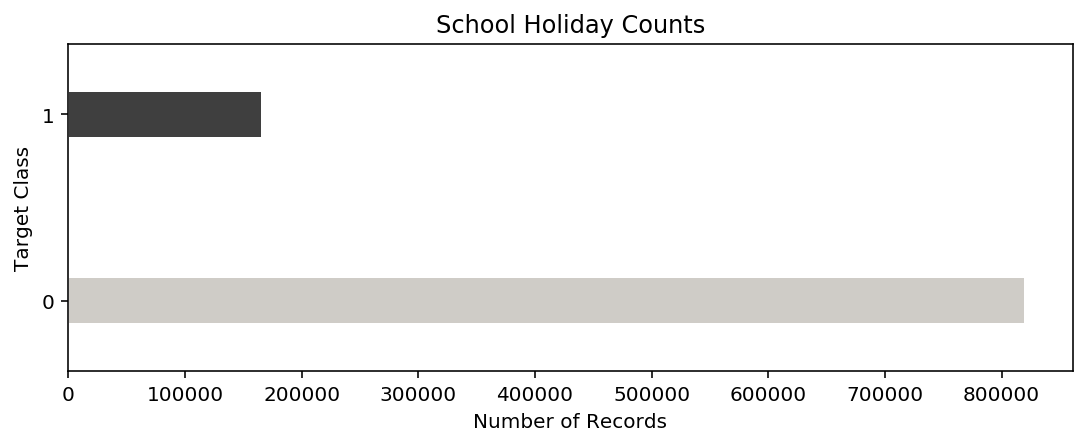

In [35]:
# Plot counts for days in the dataset a store is open
plt.figure()
open_counts = train_df.Open.value_counts()
open_counts.plot.barh(figsize=(9,3),grid=False, 
                      color=['#CFCCC7','#3F3F3F'],
                      width=0.25,edgecolor='w')
plt.title('Open Counts')
plt.ylabel('Open Classes')
plt.xlabel('Number of Records');

# Plot number of time that we are open during state holidary (probably never)
plt.figure()
sthol_counts = train_df.StateHoliday.value_counts()
sthol_counts = pd.Series([sthol_counts.values[0], 0 ]) # plotting fix
sthol_counts.plot.barh(figsize=(9,3),grid=False, 
                       color=['#CFCCC7','#3F3F3F'], 
                       width=0.25,edgecolor='w')
plt.title('Stat Holiday Counts')
plt.ylabel('Stat Holiday Classes')
plt.xlabel('Number of Records');

# Plot the number of days in the datset that are affected by school holidays
plt.figure()
schol_counts = train_df.SchoolHoliday.value_counts()
schol_counts.plot.barh(figsize=(9,3),grid=False, 
                       color=['#CFCCC7','#3F3F3F'], 
                       width=0.25,edgecolor='w')
plt.title('School Holiday Counts')
plt.ylabel('Target Class')
plt.xlabel('Number of Records');

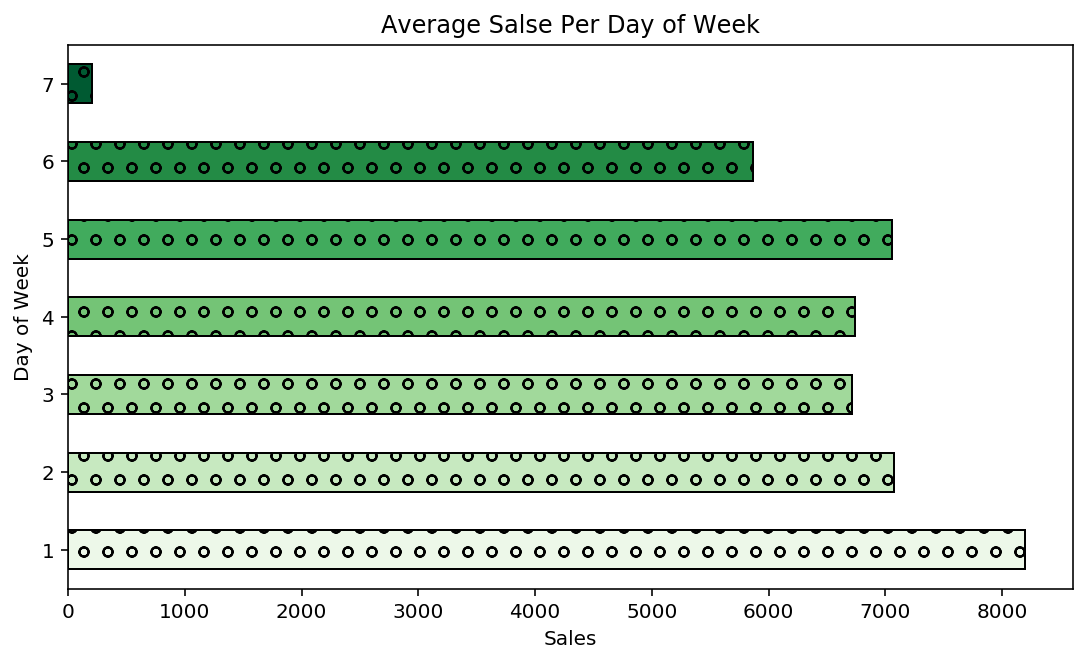

In [36]:
# plot sales by day of the week
sales_by_week = train_df.groupby('DayOfWeek')['target'].mean()
sales_by_week.plot.barh(
                figsize = (9,5),
                grid=False, 
                color=['#edf8e9','#c7e9c0','#a1d99b','#74c476',
                  '#41ab5d','#238b45','#005a32'], 
                width=0.5, edgecolor='black',
                hatch='o')
plt.title('Average Salse Per Day of Week')
plt.ylabel('Day of Week')
plt.xlabel('Sales');


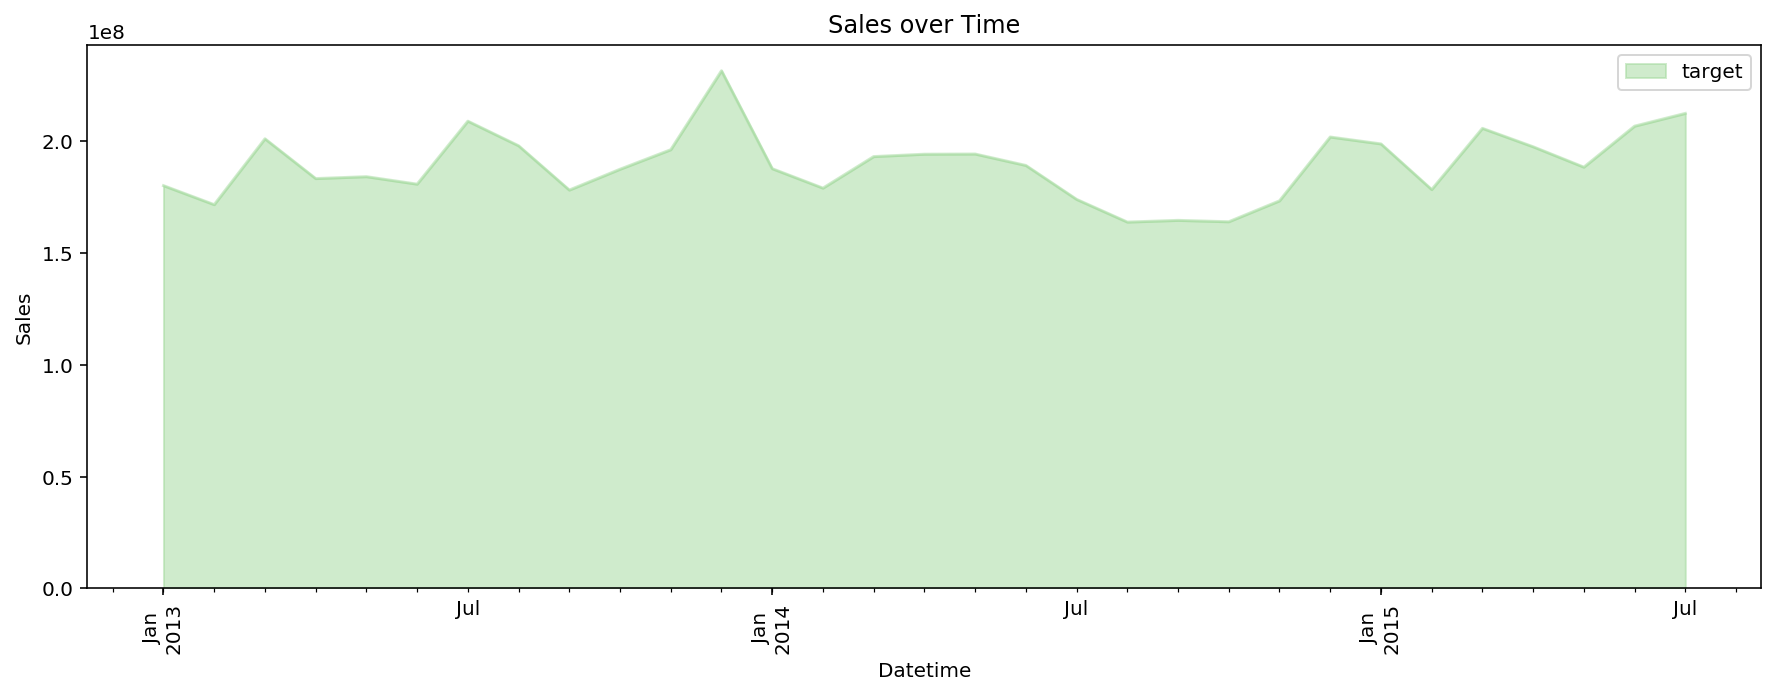

In [37]:
# Plot a line plot showing growth by year
annual_growth = train_df.set_index('Date')
annual_growth = annual_growth.resample('1M').sum()
annual_growth.plot.area(y='target', figsize=(15,5), 
                        color='#A1D99B', alpha=0.5)
plt.xticks(rotation='vertical')
plt.title('Sales over Time')
plt.xlabel('Datetime')
plt.ylabel('Sales');

The dependent variable look pretty stationary. Good from a forecasting perspective, not best for the as sales seem to be stagnating.

### Data Incosistencies

In [38]:
# Print the featuer names from each dataframe
print('Training Dataset:', train_df.columns, '\n')
print('Testing Dataset:', test_df.columns)

Training Dataset: Index(['Store', 'DayOfWeek', 'Date', 'target', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object') 

Testing Dataset: Index(['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')


We can see that training dataset has a column that is not present in our Testing Set. Therefore let's map the customers count to the storse dataset than merge the total customer counts back into the main testing and training dataframes in the next cells.

In [39]:
# Store customer information seperately
customers_df = train_df[['Store','Customers']]
customers_df = customers_df.groupby('Store')['Customers'].sum().to_frame()
customers_df.rename(columns={'Customers':'Lifetime Customers'}, inplace=True)
train_df = train_df.drop('Customers', axis=1)
customers_df.head(10)

,Lifetime Customers
Store,
1,440523
2,457085
3,584310
4,1036254
5,416813
6,493506
7,744680
8,516027
9,451677


### Data Cleaning

In [40]:
# Copy dataframe for cleaning and feature engineering
train_fdf = train_df.copy()
test_fdf = test_df.copy()
store_fdf = stores.copy()

train_fdf = train_fdf.merge(stores, how='left', on='Store')
test_fdf = test_fdf.merge(stores, how='left', on='Store')

# Deal will null values from merge
train_fdf.CompetitionOpenSinceMonth.fillna(-1, inplace=True)
train_fdf.CompetitionOpenSinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
train_fdf.Promo2.fillna(-1, inplace=True)
train_fdf.Promo2SinceWeek.fillna(-1, inplace=True)
train_fdf.Promo2SinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
train_fdf.PromoInterval.fillna('Unknown', inplace=True)

# Deal will null values after merge
train_fdf.Assortment.fillna('Unknown', inplace=True)
train_fdf.StoreType.fillna('Uknown', inplace=True)
train_fdf.CompetitionDistance.fillna(train_fdf.CompetitionDistance.mean(), inplace =True)

# View existing null value of the train dataframe
train_fdf.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
target                       0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [41]:
# Deal will null values from merge
test_fdf.CompetitionOpenSinceMonth.fillna(-1, inplace=True)
test_fdf.CompetitionOpenSinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
test_fdf.Promo2.fillna(-1, inplace=True)
test_fdf.Promo2SinceWeek.fillna(-1, inplace=True)
test_fdf.Promo2SinceYear.fillna(datetime.datetime.now().year + 1, inplace=True)
test_fdf.PromoInterval.fillna('Unknown', inplace=True)

# Deal will null values after merge
test_fdf.Assortment.fillna('Unknown', inplace=True)
test_fdf.StoreType.fillna('Uknown', inplace=True)
test_fdf.CompetitionDistance.fillna(train_fdf.CompetitionDistance.mean(), inplace =True)

# View existing null value of the test dataframe
test_fdf.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

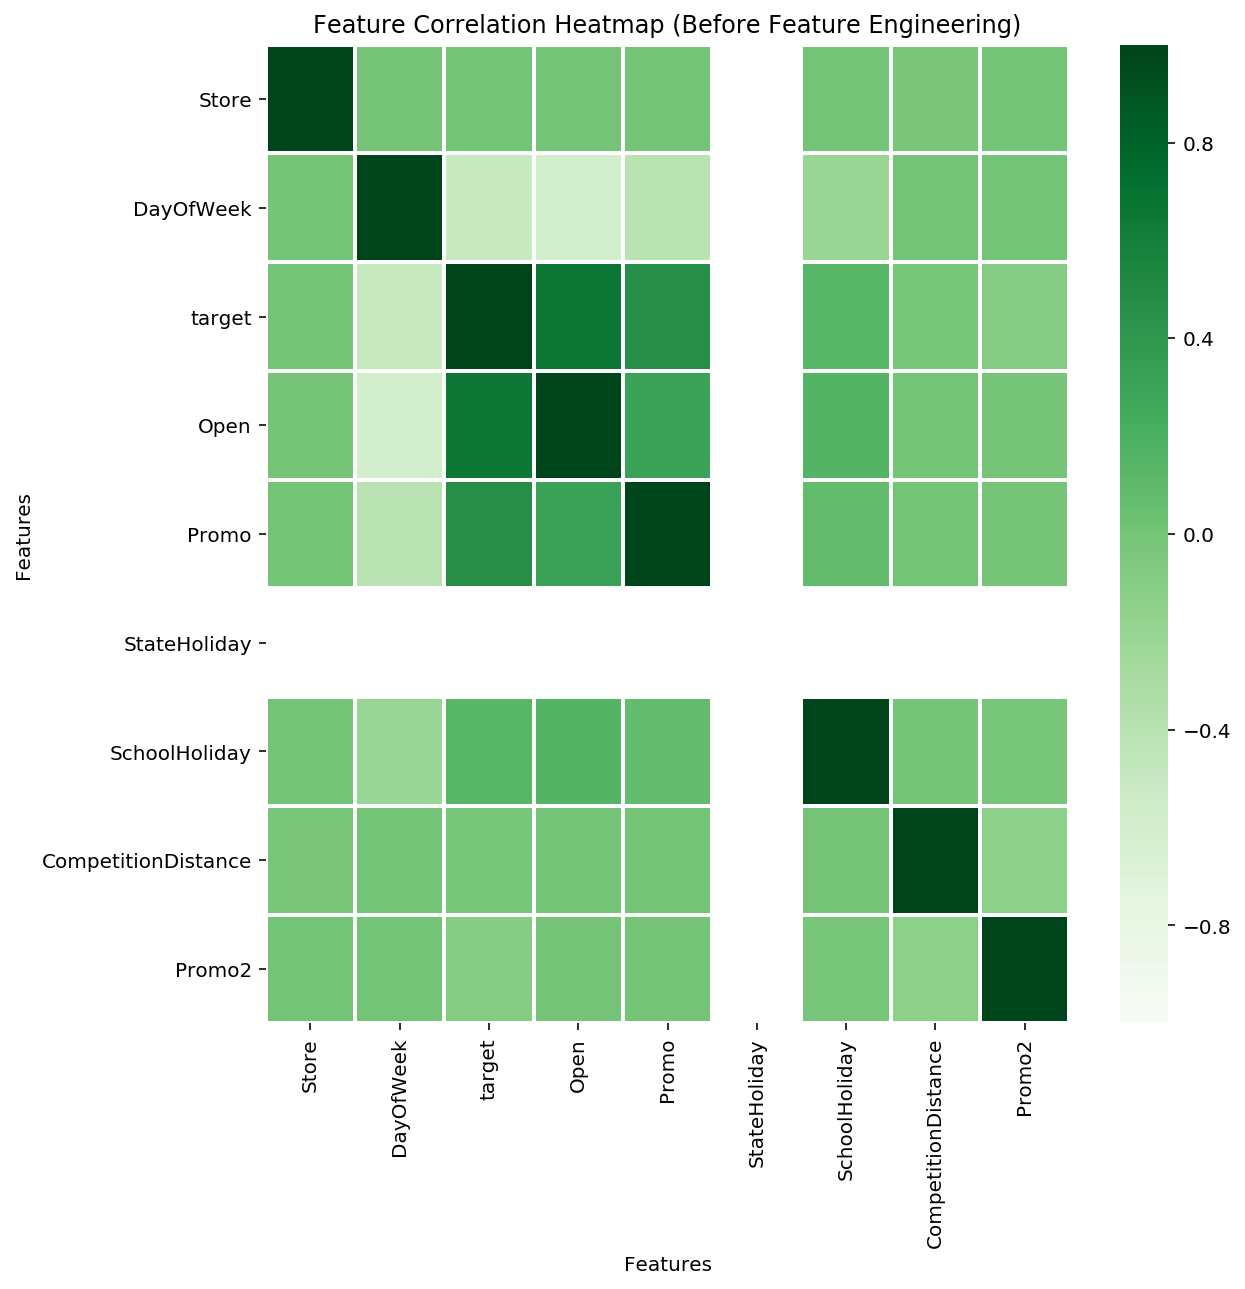

In [45]:
# Plot feature correlation matrix
plt.figure(figsize=(9,9))
sns.heatmap(train_fdf.corr(), cmap=plt.cm.Greens,linewidths=1.5,
           vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap (Before Feature Engineering)')
plt.xlabel('Features')
plt.ylabel('Features');

The strange correlation between StateHoliday and every other feature in the training set is because the StateHoliday feature is an entire feature with just the value "0". Therefore we will remove this feature at the tail end of our feature engineering.

### Feature Engineering

In [19]:
# Append Customer Information
train_fdf = train_fdf.merge(customers_df, how='left', on='Store')
test_fdf = test_fdf.merge(customers_df, how='left', on='Store')


# One Hot Encoding Train Non-Ordinal Feature
train_fdf = pd.get_dummies(train_fdf, drop_first=True,
               columns=['Assortment','Store','StoreType','Promo2',
                        'Promo2SinceYear','PromoInterval'])

# One Hot Encoding Test Non-Ordinal Feature
test_fdf = pd.get_dummies(test_fdf, drop_first=True,
               columns=['Assortment','Store','StoreType','Promo2',
                        'Promo2SinceYear','PromoInterval'])

# Expand Train DateTime Feature
train_fdf['Year'] = train_fdf['Date'].dt.year
train_fdf['Day'] = train_fdf['Date'].dt.day
train_fdf['Montah']= train_fdf['Date'].dt.month
train_fdf.drop('Date', axis=1 ,inplace=True)

# Expand Test DateTime Feature
test_fdf['Year'] = test_fdf['Date'].dt.year
test_fdf['Day'] = test_fdf['Date'].dt.day
test_fdf['Month']= test_fdf['Date'].dt.month
test_fdf.drop('Date', axis=1 ,inplace=True)

# Change the Opent Store Year into a Year Ago
train_fdf.CompetitionOpenSinceYear = (train_fdf.CompetitionOpenSinceYear.astype(int) 
                                      - datetime.datetime.now().year)
test_fdf.CompetitionOpenSinceYear = (test_fdf.CompetitionOpenSinceYear.astype(int) 
                                      - datetime.datetime.now().year)
# Drop StateHoliday Feature
train_df.drop('StateHoliday', axis=1, inplace=True )
test_df.drop('StateHoliday', axis=1, inplace=True)

### Encoding + Split Data

In [20]:
# Clean us some remaining object dtypes into ints
for df in [train_fdf, test_fdf]:
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].astype(int)

# Target Values
y = train_fdf.target
X = train_fdf.drop('target', axis=1)
print(f'Training Data Shape:',X.shape)
print(f'Training Target Shape:',y.shape)

# Create KFold cross validation rule without shuffling since we are 
# dealing with a time series
kfold = KFold(n_splits=10, shuffle=False)

Training Data Shape: (986159, 1146)
Training Target Shape: (986159,)


### Benchmark Model Pipelines

In [53]:
# Linear Regression Pipeline  (20min)
lr_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), LinearRegression())
lr_scores = cross_val_score(lr_pipeline, X, y, cv=kfold, scoring='neg_mean_absolute_error')
print(f'Linear Regression Cross Validation Score - Mean Absolute Erorr: {lr_scores.mean():.5f}')

# Fit the pipline and return predictions
lr_pipeline.fit(X,y)
lr_pred = lr_pipeline.predict(X)

Linear Regression Cross Validation Score - Mean Absolute Erorr: -2108.44595


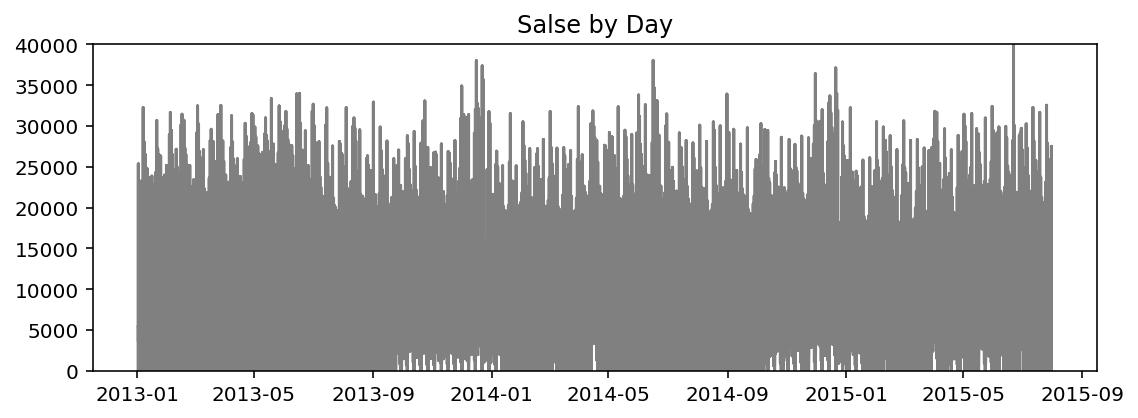

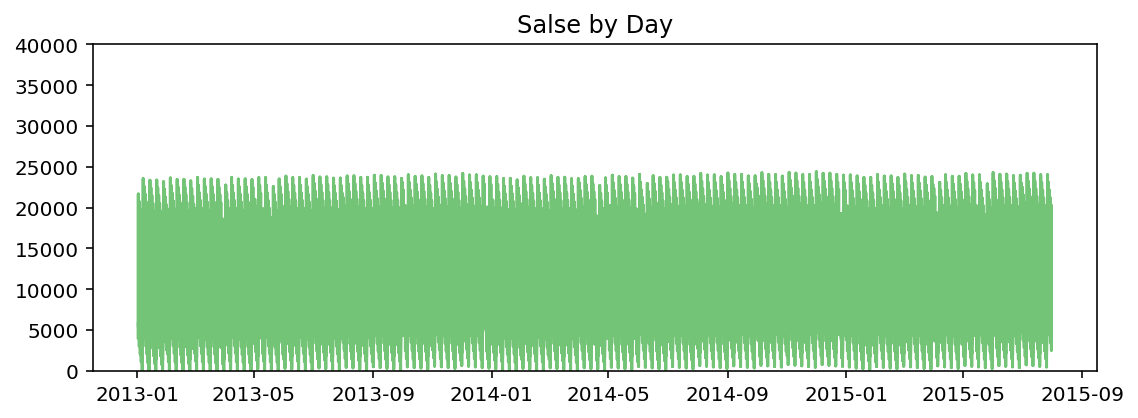

In [54]:
plt.figure(figsize=(9,3))
plt.plot(train_df.Date.values, y, color='grey')
plt.ylim(0,40_000)
plt.title("Salse by Day");

plt.figure(figsize=(9,3))
plt.plot(train_df.Date.values, lr_pred, color='#73C476')
plt.ylim(0,40_000)
plt.title("Salse by Day");

In [55]:
# Random Forest Pipeline Pipeline (40min)
rfr_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), RandomForestRegressor())
rfr_scores = cross_val_score(rfr_pipeline, X, y, cv=kfold, scoring='neg_mean_absolute_error')
print(f'Linear Regression Cross Validation Score - Mean Absolute Erorr: {rfr_scores.mean():.5f}')

# Fit Linear Regression
rfr_pipeline.fit(X,y)
rfr_pred = rfr_pipeline.predict(X)

Linear Regression Cross Validation Score - Mean Absolute Erorr: -780.53144


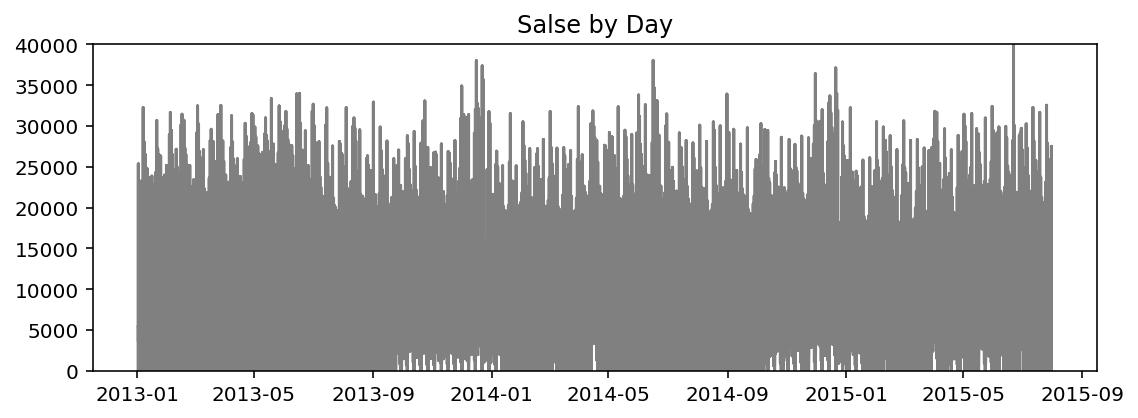

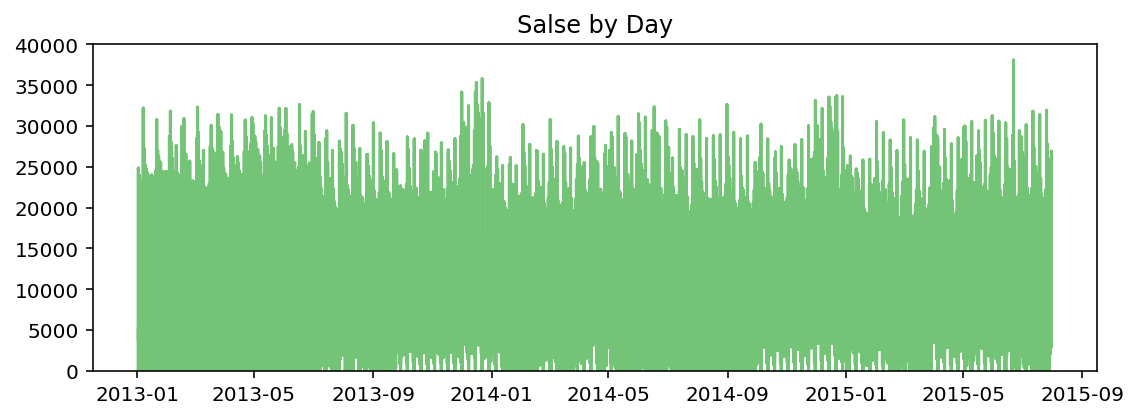

In [56]:
plt.figure(figsize=(9,3))
plt.plot(train_df.Date.values, y, color='grey')
plt.ylim(0,40_000)
plt.title("Salse by Day");

plt.figure(figsize=(9,3))
plt.plot(train_df.Date.values, rfr_pred, color='#73C476')
plt.ylim(0,40_000)
plt.title("Salse by Day");

In [ ]:
# Dense Neural Network
def create_ds_model():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(10,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_absolute_error', metrics=['mae'])
    return model

ds_model = KerasClassifier(build_fn=create_ds_model, epochs=50, batch_size=10, verbose=0)

# Linear Regression Pipeline 
ds_pipeline = make_pipeline(PCA(n_components=10),StandardScaler(), ds_model)
ds_scores = cross_val_score(ds_pipeline, X, y, cv=kfold, scoring='neg_mean_absolute_error')
print(f'Densly Connected Cross Validation Score -  Mean Absolute Error : {ds_scores.mean():.5f}')

ds_pipeline.fit(X,y)
ds_pred = lr_pipeline.predict(X)

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(train_df.Date.values, y, color='grey')
plt.ylim(0,40_000)
plt.title("Salse by Day");

plt.figure(figsize=(9,3))
plt.plot(train_df.Date.values, ds_pred, color='#73C476')
plt.ylim(0,40_000)
plt.title("Salse by Day");

### General Notes
- Data with a trend is non-stationary, Data without any trend is stationary
- Whether a trend being present in the dataset is a subject observation
- Removing a trend from your data is normally done for statistical models, but does not always work for machine learing model
- Building a Correlation Matrix Plot for the feature between the multivariate feature at different time lags, could help us find correlation within a lagged timeframe but may mask non-linearity in our model

Author: Kavi Sekhon